**Sequential changepoint detection**

Instructor: Vincent Lostanlen, LS2N, CNRS

Return to: vincent.lostanlen@ls2n.fr


Student name(s): Yassine JAMOUD & Saâd AZIZ ALAOUI & Samy HAFFOUDHI

The goal of this assignment is to detect changepoints in audio signals. For this purpose, we will use a Python library named librosa.

To learn more about librosa, visit: https://librosa.org/

In [1]:
!pip install pandas
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.metrics import precision_recall_curve
import tqdm

for module in [librosa, matplotlib, np, pd, scipy, sklearn, tqdm]:
    print("{} version: {}".format(module.__name__, module.__version__))

librosa version: 0.9.0
matplotlib version: 3.4.2
numpy version: 1.21.2
pandas version: 1.3.3
scipy version: 1.7.1
sklearn version: 0.24.2
tqdm version: 4.62.2


**Part I. Detecting a sine wave in noise**

*Exercise*

Design a real-valued signal of duration equal to two seconds. The first half should contain only white noise of amplitude 1. The second half should contain a mixture of white noise of amplitude 1 and a sine wave of amplitude `a` and frequency `f`.

In [30]:
def sine_plus_noise(a, f, sr):
    """Return a signal
    x(t) = a sin(2pi f t) + N(t)
    
    where N(t) are i.i.d. samples from the
    standard normal distribution.
    The duration of x is equal to two seconds.
    
    Parameters
    ----------
    a: signal-to-noise ratio
    f: frequency of the wave in Hertz
    decay_time: decay time in seconds
    """
    # TODO
    # Consider using np.arange, np.sin, np.randn
   
    t = np.arange(0, 2, 1/sr)
    noise = np.random.randn(t.shape[0]) 
    signal = a * np.sin(2 * np.pi * t * f)
    signal[0:sr] = 0
    return (signal+noise)

*Questions*

1. Set `sr=22050 Hz`. How many samples are there in `sine(a, f, sr)`?
2. Does the sign of `a` matter for audio perception? Why?
3. Does the sign of `f` matter for audio perception? Why?

Now let us listen to a sample.

In [31]:
a = 10.0
f = 500
sr = 22050

x = sine_plus_noise(a, f, sr)
Audio(x, rate=sr)

* **1)** Avec sr = 22050 Hz, nous avons 22050 samples puisque l'on a naturellement sr samples par secondes. Ici, le sine dure bien 1 seconde ( de 1s à 2s).

* **2)** Non, nous ne remarquons aucun changement auditif avec le signe de a.

* **3)** Comme pour le signe de a, nous ne remarquons aucun changement auditif avec le signe de f.

*Question*

4. Make sure you can hear the sine tone. Then lower the value of `a` until you can no longer hear it (given your current audio setup). What value do you find?

Let us now visualize the waveform before and after the changepoint.

* **4)** Ceci dépend de la sensibilité auditive de chacun, mais en ce qui concerne un membre de notre groupe, pour a inférieur à 0.2, on n'entend plus le sine tone.

(0.0, 2.0)

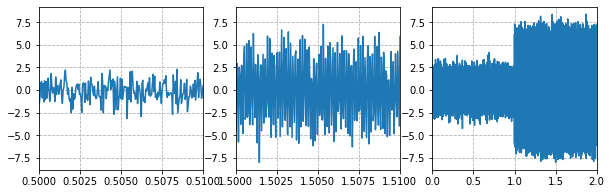

In [32]:
a = 5
f = 15000
sr = 22050

t = np.arange(0, 2, 1/sr)
x = sine_plus_noise(a, f, sr)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(t, x)
plt.grid(linestyle="--")
plt.xlim(0.5, 0.51)
plt.subplot(1, 3, 2)
plt.plot(t, x)
plt.xlim(1.5, 1.51)
plt.grid(linestyle="--")
plt.subplot(1, 3, 3)
plt.plot(t, x)
plt.grid(linestyle="--")
plt.xlim(0, 2)

*Question*

5. What do you observe when varying `a` with `f=500 Hz`?
6. Set `a` to `1` and `f` to `11025 Hz`. What happens? Explain.

On observe que :

* **5)** Avec f=500 Hz, si on augmente beaucoup a , le bruit n'a plus trop d'effet sur le sine tone ce qui est normal. Avec un a de l'ordre de grandeur de l'amplitude du bruit " a=2 par exemple " , le signal entièrement ressemble à un signal bruité.

* **6)** Avec cette configuration de a=1 et f=11025 Hz, le signal ressemble grandement au bruit blanc. On a l'impression que le signal entier est un bruit blanc. Ceci est normal au vu de la valeur de a, chose que l'on a expliqué avant, et de f=sr/2 car ...

**Part II. Waveform thresholding**

In [33]:
def evaluate(feature, a, n_trials, f=500):
    sr = 22050
    Y = []
    for _ in tqdm.tqdm(range(n_trials)):
        x = sine_plus_noise(a, f, sr)
        y = feature(x)
        Y.append(y)
    return np.array(Y)

*Question*

1. What does the `evaluate` function do?
2. What is the type of the first argument, `feature`?

Now, we evaluate a simple-minded feature for event detection, which extract the maximum value of the waveform over the time dimension.

* **1)** La fonction _evaluate_ nous permet d'évaluer le signal avec une feature spéciale chaque n_trial. On affiche également la progression de la fonction par itérations.

* **2)** Le premier argument _feature_ est une fonction python, comme _max_waveform_.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.96it/s]


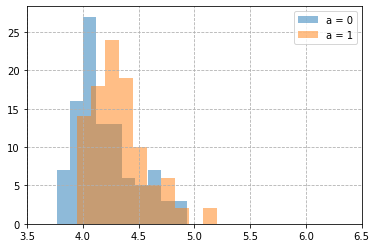

In [34]:
def max_waveform(x):
    return max(x)

Y0 = evaluate(max_waveform, a=0, n_trials=100)
Y1 = evaluate(max_waveform, a=0.5, n_trials=100)

plt.hist(Y0, alpha=0.5, label="a = 0");
plt.hist(Y1, alpha=0.5, label="a = 1");
plt.xlim(3.5, 6.5)
plt.grid(linestyle="--")
plt.legend()

*Questions*

3. Why does the output `y = feature(x)` vary between independent trials?

4. Threshold `Y1` and `Y0` with a threshold equal to `delta = 4.5`. How many TP/FP/TN/FN do you obtain?

Now, we plot a precision-recall curve for the `max_waveform` feature.

* **3)** Nous avons une variation entre les essais indépendants car la fonction evaluate appelle de nouveau dans la boucle la fonction _sine_plus_noise_. Puisque le bruit est défini avec la fonction randn, à chaque itération tqdm, nous avons une nouvelle réalisation du bruit.    
     
     
       
* **4)** Nous répondons à cette question avec ce code : 

In [35]:
delta = 4.5
FP = np.sum(Y0 >= delta)
TN = 100 - FP
TP = np.sum(Y1 >= delta)
FN = 100 - TP

print(f"TP : {TP}")
print(f"FP : {FP}")
print(f"TN : {TN}")
print(f"FN : {FN}")

TP : 19
FP : 17
TN : 83
FN : 81


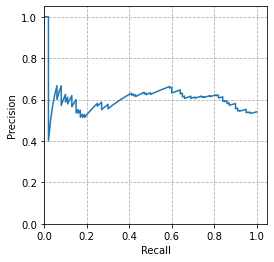

In [36]:
Y_pred = np.concatenate([Y0, Y1])
Y_true = np.concatenate([np.zeros(Y0.shape), np.ones(Y1.shape)])
precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)

plt.figure(figsize=(4, 4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(linestyle="--")

*Question*

5. Which threshold leads to highest precision?

6. Which threshold leads to highest recall?

* **5) & 6)**

In [37]:
print(f"Threshold leading to highest precision start frpm : {thresholds[-6]}")
print(f"Threshold leading to highest recall: {thresholds[0]}")

Threshold leading to highest precision start frpm : 4.867430387252458
Threshold leading to highest recall: 3.9526340252527206



*Exercises*

a. Write a function `f1_score` which computes the sequence of F1-scores associated to `precisions` and `recalls`.

b. Write a function `best_threshold` which computes the threshold yielding the best F1-score.

c. Write a function `area` which computes the area under the precision-recall curve.

In [38]:
def f1_score(precisions, recalls):
    """Compute the F1-scores associated to a sequence
    of precisions and recalls.
    
    F = 2*P*R / (P+R)
    
    where P is precision and R is recall.
    
    Parameters
    ----------
    precisions: array of precisions
    recalls: array of recalls
    """
    # TODO
    f1s = 2 * precisions * recalls / (precisions + recalls)
    return f1s


def best_threshold(f1s, thresholds):
    """Find the best threshold associated to a sequence
    of F1-scores.
    
    threshold = argmax_{tau} F(tau) 
    
    where F(tau) is the f1 score for threshold tau.
    
    Parameters
    ----------
    f1s: array of F1-scores
    thresholds: array of thresholds
    """
    # TODO
    # Consider using np.argmax
    threshold = thresholds[np.argmax(f1s)]
    return threshold


def area(precisions, recalls):
    """Compute the area under the precision-recal curve (AUPRC).
    
    Parameters
    ----------
    precisions: array of precisions
    recalls: array of recalls
    """
    # TODO
    # Consider using np.trapz
    # Consider using array[::-1] to reverse an array
    auprc = np.trapz(precisions[::-1], x=recalls[::-1])
    
    return auprc

*Questions*

7. What is the best threshold and the corresponding F1-score?

8. What is the area under the precision-recall curve (AUPRC) ?

9. What happens to AUPRC if `a=2` instead of `a=1`?

10. What happens to AUPRC if `a=0.5` instead of `a=1`?



* **7) & 8)** Nous répondons à ces questions avec les deux cellules ci-dessous : 

In [39]:
f1s = f1_score(precisions, recalls)
threshold = best_threshold(f1s, thresholds)
auprc = area(precisions, recalls)

In [40]:
print(f"best threshold: {threshold}")
print(f"Corresponding F1 score {np.max(f1s)}")
print(auprc)

best threshold: 4.107096735755147
Corresponding F1 score 0.7088607594936709
0.6034117125124597


* **9) & 10)** Pour a=1, auprc = 0.87. Pour a = 2, auprc = 0.99. Pour a=0.5, auprc = 0.61.  
     L'évolution semble normale au vu des graphes d'evaluate.
     
     
*Exercise*

d. Modify the function `evaluate` so that the waveform `x` is multiplied
by a constant `k`.

In [41]:
def evaluate_k(k, feature, a, n_trials, f=500):
    """
    Compute:
    
    Y(i) = feature(k x_i)
    
    where the signals x_i are independent
    samples of `sine_plus_noise`.
    
    Parameters
    ----------
    k: gain factor
    feature: feature extractor
    a: amplitude
    n_trials: number of signals x_i
    f: sine wave frequency in Hertz
    """
    sr = 22050
    Y = []
    for trial in tqdm.tqdm(range(n_trials)):
        x = k * sine_plus_noise(a, f, sr)
        y = feature(x)
        Y.append(y)
    return np.array(Y)

*Question*

11. Run `evaluate_k` with `k=2`. What is the best threshold and F1-score? What is the AUPRC?

12. Same question with `k=0.5`.

13. Is the `max_waveform` feature invariant or equivariant to multiplication by `k`?

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.53it/s]


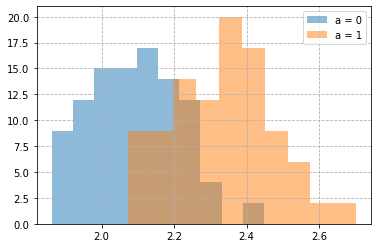

In [42]:
Y0 = evaluate_k(0.5, max_waveform, 0, 100)
Y1 = evaluate_k(0.5, max_waveform, 1, 100)

plt.hist(Y0, alpha=0.5, label="a = 0");
plt.hist(Y1, alpha=0.5, label="a = 1");
plt.grid(linestyle="--")
plt.legend()

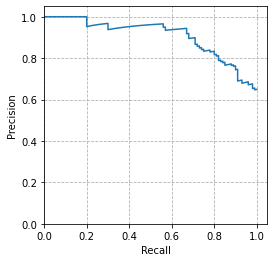

In [43]:
Y_pred = np.concatenate([Y0, Y1])
Y_true = np.concatenate([np.zeros(Y0.shape), np.ones(Y1.shape)])
precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)

plt.figure(figsize=(4, 4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(linestyle="--")

In [44]:
print(f"Threshold leading to highest precision start frpm : {thresholds[-6]}")
print(f"Threshold leading to highest recall: {thresholds[0]}")

Threshold leading to highest precision start frpm : 2.558280591273504
Threshold leading to highest recall: 2.071432488999196


* **11)** Voici les valeurs pour k=2 :

In [45]:
f1s = f1_score(precisions, recalls)
threshold = best_threshold(f1s, thresholds)
auprc = area(precisions, recalls)

print(f"best threshold: {threshold}")
print(f"Corresponding F1 score {np.max(f1s)}")
print(f"AUPRC: {auprc}")

best threshold: 2.162339225576701
Corresponding F1 score 0.8256880733944953
AUPRC: 0.9059941750779001


* **11)** Pour k=2 :     
        Best threshold = 8.63
        AUPRC = 0.896
        
* **12)** Pour k=0.5 :     
        Best threshold = 2.20
        AUPRC = 0.84
        
* **13)** On peut conclure grâce à cette analyse que _max_waveform_ est équivariant par rapport à k en ce qui concerne le best  threshold. En effet, nous avons divisé k par 4, et le best threshold a également été divisé par 4. Nonobstant, aucune différence n'est remarquée par rapport à la valeur de l'AUPRC 

**Part III. Spectral flux**

In this part, we will try to improve the simple-minded feature above (`max_waveform`).

We will design another feature: spectral flux; that is, the rectified temporal first-order difference of the spectrogram, followed by global maximum pooling over the time-frequency domain.

*Exercise*

Write a function `spectral_flux` which extracts:

```
flux = max_{t, f} max(S(t+1, f) - S(t, f), 0)
```

where `S` is the spectrogram of the signal `x`.

In [46]:
def spectral_flux(x):
    """Spectral flux (linear amplitude scaling).
    
    flux = max_{t, f} max(S(t+1, f) - S(t, f), 0)
    
    Parameters
    ----------
    x: input signal
    """
    S = np.abs(librosa.stft(x))
    # Consider using: np.diff, np.maximum, np.max
    flux = np.max(np.max(np.diff(S, 1)), 0)
    return flux

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.35it/s]


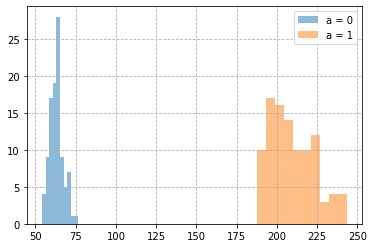

In [47]:
Y0 = evaluate_k(1, spectral_flux, a=0, n_trials=100, f=100)
a = 1
Y1 = evaluate_k(1, spectral_flux, a=a, n_trials=100, f=100)

plt.hist(Y0, alpha=0.5, label="a = 0");
plt.hist(Y1, alpha=0.5, label="a = {}".format(a));
plt.grid(linestyle="--")
plt.legend()

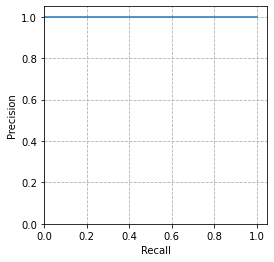

In [48]:
Y_pred = np.concatenate([Y0, Y1])
Y_true = np.concatenate([np.zeros(Y0.shape), np.ones(Y1.shape)])
precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)

plt.figure(figsize=(4, 4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(linestyle="--")

In [49]:
auprc = area(precisions, recalls)
print(f"AUC: {auprc}")

AUC: 1.0


*Questions*
1. Evaluate spectral flux with `a=0` versus `a=1`. What results do you obtain?

2. What is the area under the precision-recall curve (AUPRC) ?

3. What happens to AUPRC if `a=0.5` instead of `a=1`?

4. What happens to AUPRC if `a=0.25` instead of `a=1`?

5. Is the `spectral_flux` feature invariant or equivariant to frequency `f`? Why?

6. Is the `spectral_flux` feature invariant or equivariant to multiplication by `k`? Why?


* **1)** On observe que le flux spectral d'un signal sans le sine tone _a=0_ est beaucoup plus faible que celui avec _a=1_. De fait, les deux parties de l'histogramme ne se recouvrent pas et notre ROC vaut donc toujours 1.    
                    
                    
                    
                    
* **2)** Puisque le ROC vaut toujours 1, l'auc vaut naturellement 1 aussi vu que l'aire sous la courbe est un carré de côté 1.
                 
                 
                 
                 
* **3)** Avec _a=0.5_, on obtient également un auc de 1. Les deux parties de l'histogramme se touchent à peine mais ne se recouvrent pas.
                          
                          
                          
                          
                          
* **4)** Avec _a=0.25_, on obtient un auc d'environ 0.73. Plus on augmente a , plus l'auc baisse ce qui est normal.
                
                
                
* **5)** En ce qui concerne les questions d'invariance, puisque la  réalisation du bruit change à chaque fois qu'on lance la fonction, on ne peut pas trop se fier aux valeurs numériques. Cependant, nous allons quand même nous baser sur les histogrammes pour répondre à cette question. Pour f = 1000 ou f = 250, on voit que les histogrammes ne changent pas du tout. Le _spectral_flux_ est donc invariant par rapport à _f_.
                
                
* **6)** Pour la multiplication par k, on remarque une équivariance car quand on multiplie k par 10 par exemple, les valeurs d'abscisse de l'histogramme sont multipliées par 10

**Part IV. Logarithmic transformation**

In this part, we will modify the spectral flux so that it computes rectified differences over the *logarithms* of spectrogram magnitudes.

*Exercise*


Write a function `decibel_flux` which extracts:

```
flux = max_{t, f} max(10 log_10 S(t+1, f) - 10 log_10 S(t, f), 0)
```

where `S` is the magnitude spectrogram of the signal `x`.

In [50]:
def decibel_flux(x):
    """Spectral flux (logarithmic amplitude scaling).
    
    flux = max_{t, f} max(10 log_10 S(t+1, f) - 10 log_10 S(t, f), 0)
    
    Parameters
    ----------
    x: input signal
    """
    S = np.abs(librosa.stft(x))
    # Consider using: np.log10, np.diff, np.maximum, np.max
    flux = np.max(np.max(10 * np.diff(np.log10(S), 1)), 0)
    return flux

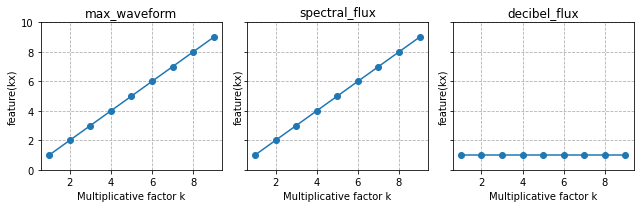

In [63]:
x = sine_plus_noise(a=1, f=500, sr=22050)

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
for i, feature in enumerate([max_waveform, spectral_flux, decibel_flux]):
    ax[i].plot(range(1, 10), [feature(k*x)/feature(x) for k in range(1, 10)], "-o")
    ax[i].set_ylim(0, 10)
    ax[i].set_ylim(0, 10)
    ax[i].grid(linestyle="--")
    ax[i].set_xlabel("Multiplicative factor k")
    ax[i].set_ylabel("feature(kx)")
    ax[i].set_title(feature.__name__)
plt.tight_layout()

1. Is the `decibel_flux` feature invariant or equivariant to frequency `f`? Why?

2. Is the `decibel_flux` feature invariant or equivariant to multiplication by `k`? Why?

* **1)** De même que pour le _spectral_flux_, le _decibel_flux_ semble être invariant aux changements de fréquence f.

* **2)** Le graphique ci-dessus montre que _decibel_flux_ est également invariant aux multiplications par k. Ceci est du à la difference de deux log contenant la multiplication par k. log(a*b) = log(a) + log(b), la différence enlève l'influence de k.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.11it/s]


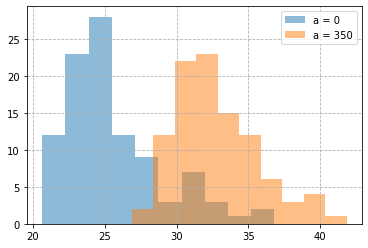

In [69]:
Y0 = evaluate(decibel_flux, a=0, n_trials=100)
a = 350
Y1 = evaluate(decibel_flux, a=a, n_trials=100)

plt.hist(Y0, alpha=0.5, label="a = 0");
plt.hist(Y1, alpha=0.5, label="a = {}".format(a));
plt.grid(linestyle="--")
plt.legend()

0.9054868691763867

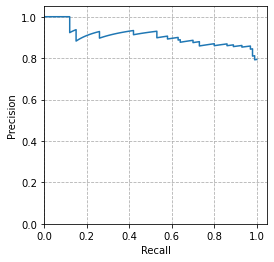

In [70]:
Y_pred = np.concatenate([Y0, Y1])
Y_true = np.concatenate([np.zeros(Y0.shape), np.ones(Y1.shape)])
precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)

plt.figure(figsize=(4, 4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(linestyle="--")

area(precisions, recalls)

*Questions*

1. Evaluate spectral flux with `a=0` versus `a=1`. What results do you obtain?
**Vous voulez dire decibel flux ? Nous avons déjà répondu à cette question pour spectral flux.**

2. What is the area under the precision-recall curve (AUPRC) ?

3. Raise `a` until the AUPRC is at least `0.9`. What value of `a` do you get?

4. Explain why `decibel_flux` is worse than `spectral_flux` in low-SNR (low `a`) settings.

* **1)** On observe que le flux décibel d'un signal sans le sine tone _a=0_ prend les mêmes valeurs que celui avec _a=1_ , mais il y'a plus de valeurs chez _a=1_. De fait, les deux parties de l'histogramme se recouvrent et notre ROC est faible.    
                    
                    
                    
                    
* **2)** On trouve une valeur d'AUPRC d'environ 0.55
                 
                 
                 
                 
* **3)** Avec _a=350_, on obtient un AUPRC d'environ 0.9
                          
                          
                          
                          
                          
* **4)** Pour des _a_ faibles, _decibel_flux_ est moins pertinent que _spectral_flux_ à cause de la présence du logarithme.       
                
                

**Part V. Per-Channel Energy Normalization**

In this section, we will apply per-channel energy normalization (PCEN) onto the spectrogram as an alternative to decibel-scaled spectral flux.

*Exercise*

Write a function `max_pcen` which extracts

```
maxP = max_{t,f} E[t, f] / M[t, f]
```

where `E` is the magnitude scalogram of `x` and
```
M[t, f] = 1/(1+t) \sum_{tau<=t} E[tau, f]
```

is the cumulative mean of `E` over the time dimension.

Try vectorizing your code! Use `np.cumsum` instead of a `for` loop.

In [71]:
def max_pcen(x):
    """Maximum-pooled PCEN.
    
    maxP = max_{t,f} E[t, f] / M[t, f]
    
    Parameters
    ----------
    x: input signal
    """
    E = np.abs(librosa.stft(x))
    M = np.cumsum(E, axis=0)
    t = np.linspace(0, 2, M.shape[0])
    t = t[np.newaxis]
    t = t.T
    M = M / t
    # Consider using: np.arange, np.cumsum, np.newaxis, np.max
    
    E /= M
    
    maxP = np.amax(E)
    return maxP

*Questions*

1. Is the `max_pcen` feature invariant or equivariant to frequency `f`? Why?

2. Is the `max_pcen` feature invariant or equivariant to multiplication by `k`? Why?

1) On voit bien sur les codes qui sont ci-dessous que _max_pcen_ est invariant par rapport aux changements fréquentiels.         
2) On voit bien sur les codes qui sont ci-dessous que _max_pcen_ est invariant par rapport aux multiplications par k. La raison est que l'on voit dans la formule que la normalisation annule l'influence de k. La méthode semble être plus robuste aux distorsions de canaux.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-71-512aa57f9b24>:15: RuntimeWarning: divide by zero encountered in true_divide
  M = M / t
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.24it/s]


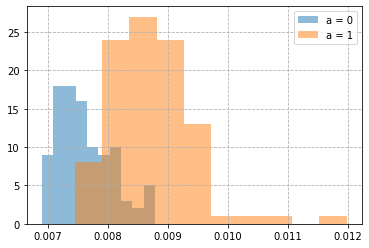

In [98]:
Y0 = evaluate(max_pcen, a=0, n_trials=100, f=5000)
a = 0.14
Y1 = evaluate(max_pcen, a=a, n_trials=100, f=5000)

plt.hist(Y0, alpha=0.5, label="a = 0");
plt.hist(Y1, alpha=0.5, label="a = 1".format(a));
plt.grid(linestyle="--")
plt.legend()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-71-512aa57f9b24>:15: RuntimeWarning: divide by zero encountered in true_divide
  M = M / t
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.89it/s]


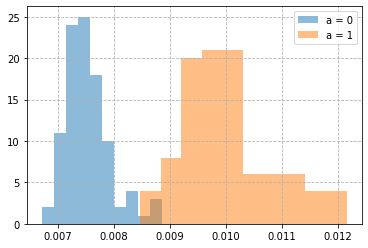

In [79]:
Y0 = evaluate_k(0.1, max_pcen, 0, 100)
Y1 = evaluate_k(0.1, max_pcen, 0.2, 100)

plt.hist(Y0, alpha=0.5, label="a = 0");
plt.hist(Y1, alpha=0.5, label="a = 1");
plt.grid(linestyle="--")
plt.legend()

0.9206609266465554

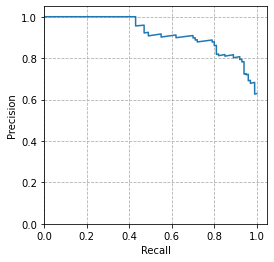

In [99]:
Y_pred = np.concatenate([Y0, Y1])
Y_true = np.concatenate([np.zeros(Y0.shape), np.ones(Y1.shape)])
precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)

plt.figure(figsize=(4, 4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(linestyle="--")

area(precisions, recalls)

*Questions*

3. Evaluate PCEN with `a=0` versus `a=1`. What results do you obtain?

4. Lower `a` until the AUPRC is below `0.9`. What value of `a` do you get?

5. What is the resemblance between `pcen` and `decibel_flux`? What is the difference?

* **3)** On obtient la même chos que pour le _spectral_flux_. Le flux spectral d'un signal sans le sine tone _a=0_ est beaucoup plus faible que celui avec _a=1_. De fait, les deux parties de l'histogramme ne se recouvrent pas et notre ROC vaut donc toujours 1.                                              
                                            
* **4)** On obtient une valeur de a d'environ 0.14.

* **5)**  

**Part VI. Analysis of variance**

In this, section, we will perform an analysis of variance (ANOVA) between two groups: before and after the 

*Exercise*

Write a function `anova(x)` which extracts

```
maxR = max_{t,f} V[f] / (V_past[t, f] + V_future[t, f])
```

where `V = (\sum_{t,f} E[t,f]**2) - (\sum_{t,f} E[t,f])**2` is the global per-channel variance of `E` and `V_past[t,f]` (resp. `V_future[t,f]`) are the per-channel variances before (resp. after) a candidate changepoint `t`.

Try vectorizing your code! Use `np.cumsum` instead of a `for` loop.

In [100]:
def anova(x):
    """Analysis of Variance (ANOVA).
    
    maxR = max_{t,f} V[f] / (V_past[t, f] + V_future[t, f])
    
    Parameters
    ----------
    x: input signal
    """
    E = np.abs(librosa.stft(x))
    # Consider using:
    # np.arange, np.cumsum, np.newaxis, np.var, np.max
        
    V = np.var(E, axis = 1)
    
    t = np.arange(1, E.shape[1]+1)

    somme_E = np.cumsum(E, axis = 1)/t
    somme_E_2 = np.cumsum(E**2, axis = 1)/t
    V_past = somme_E_2 - somme_E**2
    
    somme_E_inv = np.cumsum(E[:,::-1], axis = 1)/t
    somme_E2_inv = np.cumsum(E[:,::-1]**2, axis = 1)/t
    V_future = (somme_E2_inv[:,::-1] - somme_E_inv[:,::-1]**2)
    
    max_ratio = (V[:, np.newaxis]/(V_past+V_future)).max()
    
    return max_ratio

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.01it/s]


0.8758366735049392

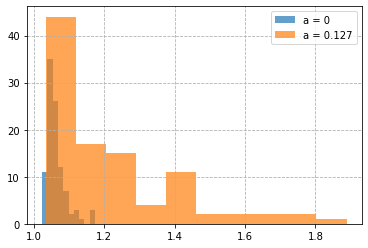

In [110]:
Y0 = evaluate(anova, a=0, n_trials=100, f = 500)
a = 0.127
Y1 = evaluate(anova, a=a, n_trials=100, f = 500)

plt.hist(Y0, alpha=0.7, label="a = 0");
plt.hist(Y1, alpha=0.7, label="a = {}".format(a));
plt.grid(linestyle="--")
plt.legend()

Y_pred = np.concatenate([Y0, Y1])
Y_true = np.concatenate([np.zeros(Y0.shape), np.ones(Y1.shape)])
precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)

area(precisions, recalls)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.46it/s]


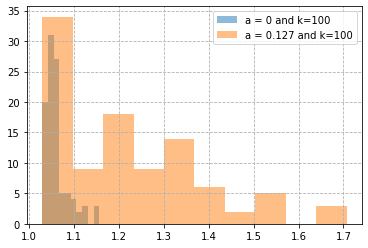

In [108]:
Y0 = evaluate_k(100, anova, 0, 100)
Y1 = evaluate_k(100, anova, 0.127, 100)

plt.hist(Y0, alpha=0.5, label="a = 0 and k=100");
plt.hist(Y1, alpha=0.5, label="a = 0.127 and k=100");
plt.grid(linestyle="--")
plt.legend()

*Questions*

1. Is the `anova` feature invariant or equivariant to frequency `f`? Why?

2. Is the `anova` feature invariant or equivariant to multiplication by `k`? Why?

3. Evaluate `anova` with `a=0` versus `a=1`. What results do you obtain?

4. Lower `a` until the AUPRC is below `0.9`. What value of `a` do you get?

5. Is there a drawback of using `anova` versus all other proposed methods?

* **1)** _Anova_ est invariant par rapport aux changements fréquentiels car la fréquence ne change pas la variance, et donc les calculs autour d'elle.   
                    
                    
                    
                    
* **2)** _Anova_ est invariant par rapport aux multiplications par k car ?
                 
                 
                 
                 
* **3)** On obtient un recouvrement totalement nul, donc un AUPRC de 1.
                          
                          
                          
                          
                          
* **4)** Avec _a=0.127_, oo obtient des AUPRC d'environ 0.9.
                
                
                
* **5)**  


**Part VI. Benchmark**

In [33]:
sr = 22050
n_trials = 100
f = 500
amplitudes = [-20, -15, -10] + list(range(-10, 1)) + [3, 6, 9, 12, 15, 20, 25, 30]
AUPRC = {}
features = [max_waveform, spectral_flux, decibel_flux, max_pcen, anova]
Y0 = {feature.__name__: [] for feature in features}

for trial in tqdm.tqdm(range(n_trials)):
    x = sine_plus_noise(a=0, f=f, sr=sr)
    for feature in features:
        y = feature(x)
        Y0[feature.__name__].append(y)
    
for feature in features:
    Y0[feature.__name__] = np.array(Y0[feature.__name__])

for a_dB in tqdm.tqdm(amplitudes):
    a = 10**(a_dB/10)
    for feature in features:
        AUPRC[(a_dB, feature.__name__)] = []
    Y1 = {feature.__name__: [] for feature in features}
    for trial in range(n_trials):
        x = sine_plus_noise(a=a, f=f, sr=sr)
        for feature in features:
            Y1[feature.__name__].append(feature(x))
    for feature in features:
        Y1[feature.__name__] = np.array(Y1[feature.__name__])
        Y_pred = np.concatenate([Y0[feature.__name__], Y1[feature.__name__]])
        Y_true = np.concatenate([
            np.zeros(Y0[feature.__name__].shape), np.ones(Y1[feature.__name__].shape)])
        precisions, recalls, thresholds = precision_recall_curve(Y_true, Y_pred)
        AUPRC[(a_dB, feature.__name__)].append(area(precisions, recalls))

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-26-512aa57f9b24>:15: RuntimeWarning: divide by zero encountered in true_divide
  M = M / t
  5%|███▊                                                                               | 1/22 [00:02<00:44,  2.12s/it]<ipython-input-26-512aa57f9b24>:15: RuntimeWarning: divide by zero encountered in true_divide
  M = M / t
  9%|███████▌                                                                           | 2/22 [00:04<00:42,  2.15s/it]<ipython-input-26-512aa57f9b24>:15: RuntimeWarning: divide by zero encountered in true_divide
  M = M / t
 14%|███████████▎                                                                       | 3/22 [00:06<00:43,  2.29s/it]<ipython-input-26-512aa57f9b24>:15: RuntimeWarning: divide by zero encountered in true_divide
  M = M / t
 18%|███████████████                                                                    | 4/22 [00:0

Text(0.5, 1.0, 'Changepoint detection benchmark')

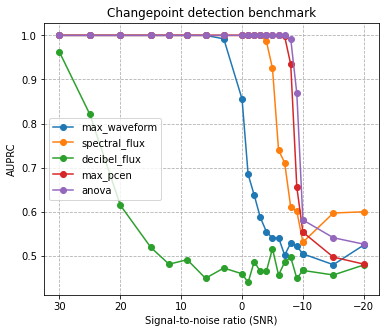

In [34]:
plt.figure(figsize=(6, 5))
for feature in features:
    plt.plot(amplitudes, [AUPRC[a, feature.__name__] for a in amplitudes], "-o", label=feature.__name__)
plt.legend()
plt.gca().invert_xaxis()
plt.grid(linestyle="--")
plt.xlabel("Signal-to-noise ratio (SNR)")
plt.ylabel("AUPRC")
plt.title("Changepoint detection benchmark")

*Questions*

1. Execute the code above. What does it do? Which system is the best?

2. Rate systems from best to worst in terms of robustness to noise.

3. Which of these systems invariant to multiplication by `k`?

4. Which are spectrogram-based?

5. Which take temporal context into account beyond one spectrogram frame?

6. Which are causal?

* **1)** Le code permet de faire un " Benchmark " des différentes méthodes définies tout au long du TP. On obtient une comparaison de l'AUPRC par rapport à la valeur du SNR pour les 5 méthodes. Le système le plus performant est _Anova_.
                    
                    
                    
                   
* **2)** Anova > max_pcen > spectral_flux > max_waveform > decibel_flux.
                 
                 
                 
                 
* **3)** Les systèmes invariants à la multiplication par k sont : Anova , max_pcen et decibel_flux.
                          
                          
                          
                          
* **4)** 
                
                
                
* **5)** Seul anova prend le contexte temporel


* **6)** Tous les systèmes sont causaux sauf anova qui utilise le passé et le futur. La sortie peut précéder l'entrée.
